In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import sys
import os
from misc import rcsetup

from ImageData import ImageData, preprocess
from FileManager import FileManager

rcsetup()

sys.path.append("../")

from feature_decomp import generate_fra_monomials
from data import get_powerlaw
from kernels import GaussianKernel, LaplaceKernel
from utils import ensure_torch

### Synthetic Data

In [5]:
DATA_DIM = 20
KERNEL_WIDTH = 4
P_MODES = 100_000
kerneltype = LaplaceKernel
data_eigval_exp = 1.

data_eigvals = get_powerlaw(DATA_DIM, data_eigval_exp, offset=3)

d_eff = 1/(data_eigvals**2).sum()
print(f"effective dim = {d_eff:.2f}")

eval_level_coeff = kerneltype.get_level_coeff_fn(data_eigvals=data_eigvals,
                                                 kernel_width=KERNEL_WIDTH)
fra_eigvals, monomials = generate_fra_monomials(data_eigvals, P_MODES, eval_level_coeff)
degrees = np.array([m.degree() for m in monomials])

effective dim = 13.69


### Gaussian Data

In [19]:
N_SAMPLES = 20_000
KERNEL_WIDTH = 4
P_MODES = 100_000
zca_strength = 1e-2
kerneltype = LaplaceKernel

datapath = os.getenv("DATASETPATH")
assert datapath is not None
cifar10 = ImageData('cifar10', datapath, classes=None)
X_raw, _ = cifar10.get_dataset(N_SAMPLES, get="train")
X = preprocess(X_raw, center=True, grayscale=True, zca_strength=zca_strength)
X = ensure_torch(X)
# ensure typical sample has unit norm
S = torch.linalg.svdvals(X)
X *= torch.sqrt(N_SAMPLES / (S**2).sum())
data_eigvals = S**2 / (S**2).sum()

d_eff = 1/(data_eigvals**2).sum()
print(f"effective dim = {d_eff:.2f}")

eval_level_coeff = kerneltype.get_level_coeff_fn(data_eigvals=data_eigvals,
                                                 kernel_width=KERNEL_WIDTH)
fra_eigvals, monomials = generate_fra_monomials(data_eigvals, P_MODES, eval_level_coeff)
degrees = np.array([m.degree() for m in monomials])

effective dim = 26.00


### Plot

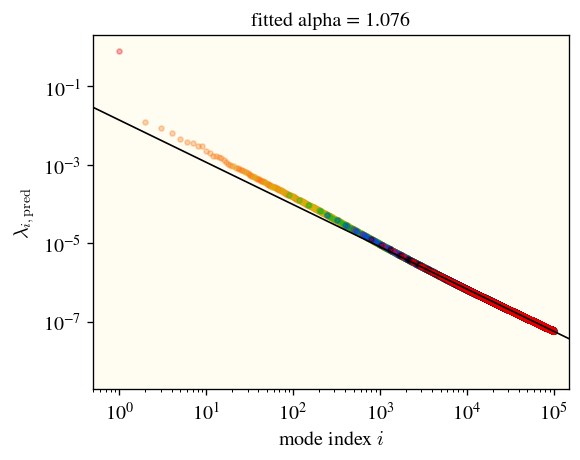

In [20]:
def fit_linear(idxs, eigvals, cutoff=20_000):
    log_x = np.log(idxs[-cutoff:])
    log_y = np.log(eigvals[-cutoff:])
    A     = np.vstack([log_x, np.ones_like(log_x)]).T
    slope, intercept = np.linalg.lstsq(A, log_y, rcond=None)[0]

    alpha = -slope

    return alpha, np.exp(intercept)

colors = ['xkcd:red', 'xkcd:orange', 'xkcd:gold', 'xkcd:green', 'xkcd:blue', "xkcd:purple", "xkcd:black"]

fig, ax = plt.subplots(1, 1, figsize=(5,4))

for degree in np.unique(degrees):
    if degree > 7:
        continue
    idxs = np.where(np.array(degrees) == degree)[0]
    ax.scatter(1+idxs, fra_eigvals[idxs], color=colors[degree%7], marker='.', alpha=0.3)

idxs = 1+np.arange(len(fra_eigvals))
alpha, c = fit_linear(idxs, fra_eigvals, cutoff=99_000)
xx = np.logspace(-1, 6, base=10)
ax.plot(xx, c*xx**(-alpha), color='black', lw=1)
ax.set_title(f"fitted alpha = {alpha:.3f}")

ax.set_xlim(.5, 1.5*P_MODES)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(f'mode index $i$')
ax.set_ylabel(f'$\lambda_{{i,\mathrm{{pred}}}}$')

plt.tight_layout()
plt.show()